In [3]:
from vnstock import Vnstock
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import requests

In [8]:
from math import sqrt


def get_port_price(symbols, start_date, end_date):

    result = pd.DataFrame()


    for s in symbols:

        stock = Vnstock().stock(symbol=s, source="TCBS")

        df = stock.quote.history(start=start_date, end=end_date, interval="1D")

        if result.empty:

            result["time"] = df["time"]

        result[s] = df["close"]

    result.set_index("time", inplace=True)
    return result



def get_port(price, N=252):

    port_ret = np.log(price / price.shift(1))
    port_annual_risk = np.sqrt(port_ret.std() * sqrt(N))
    port_annual_ret = ((1 + port_ret.mean()) ** N) - 1

    sharpe_ratio = port_annual_ret / port_annual_risk
    result = pd.DataFrame(
        {
            "DailyReturn": port_ret.mean(),
            "DailyRisk": port_ret.std(),
            "AnnualReturn": port_annual_ret,
            "AnnualRisk": port_annual_risk,
            "Sharpe Ratio": sharpe_ratio,
        }
    )
    return result

In [2]:
symbols = ["ACB", "MBB", "TCB"]
price = get_port_price(symbols, "2014-01-01", "2025-01-01")

NameError: name 'pd' is not defined

In [ ]:
port = get_port(price, 252)
port

,DailyReturn,DailyRisk,AnnualReturn,AnnualRisk,Sharpe Ratio
ACB,0.000761,0.017381,0.211438,0.525283,0.402522
MBB,0.000710,0.018117,0.195755,0.536285,0.365022
TCB,0.000238,0.020598,0.061743,0.571827,0.107976


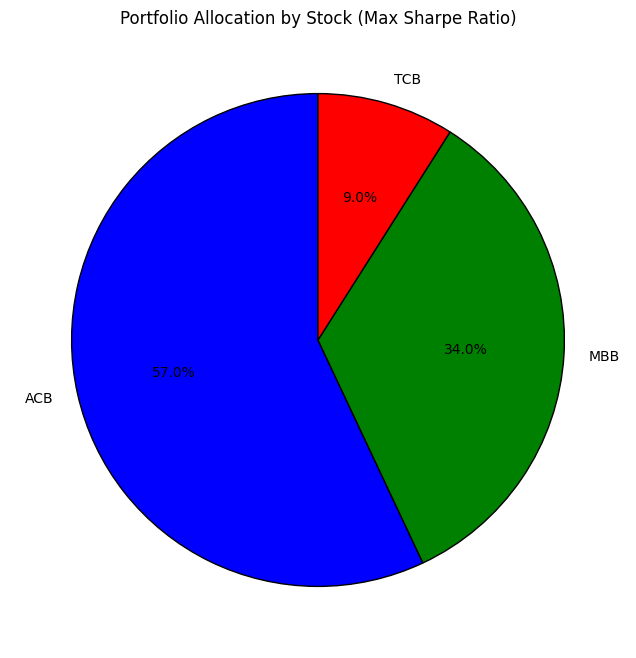

In [ ]:
def calculate_optimal_portfolio(symbols, price, port, no_of_port=10000, risk_free_rate=0.0267):
    num_stocks = len(symbols)
    weight = np.zeros((no_of_port, num_stocks))
    expected_ret = np.zeros(no_of_port)
    expected_vol = np.zeros(no_of_port)
    sharpe_ratio = np.zeros(no_of_port)

    port_ret = np.log(price / price.shift(1))

    for i in range(no_of_port):
        weight_random = np.random.random(num_stocks)
        weight_random /= np.sum(weight_random)
        weight[i, :] = weight_random
        expected_ret[i] = np.sum(port["AnnualReturn"] * weight_random)
        expected_vol[i] = np.sqrt(
            np.dot(weight_random.T, np.dot(port_ret.cov() * 252, weight_random))
        )
        sharpe_ratio[i] = (expected_ret[i] - risk_free_rate) / expected_vol[i]

    max_sharpe_index = sharpe_ratio.argmax()
    max_return_index = expected_ret.argmax()
    min_risk_index = expected_vol.argmin()

    optimal_portfolio = pd.DataFrame(
        {
            "Symbols": symbols,
            "Max Sharpe Weight": weight[max_sharpe_index, :].round(decimals=2) * 100,
            "Max Return Weight": weight[max_return_index, :].round(decimals=2) * 100,
            "Min Risk Weight": weight[min_risk_index, :].round(decimals=2) * 100,
        }
    )

    return optimal_portfolio


optimal_portfolio = calculate_optimal_portfolio(symbols, price, port)
# Create a pie chart for the portfolio weights
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    optimal_portfolio["Max Sharpe Weight"],
    labels=optimal_portfolio["Symbols"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["blue", "green", "red"],
    wedgeprops={"edgecolor": "black"},
)
ax.set_title("Portfolio Allocation by Stock (Max Sharpe Ratio)")
plt.show()

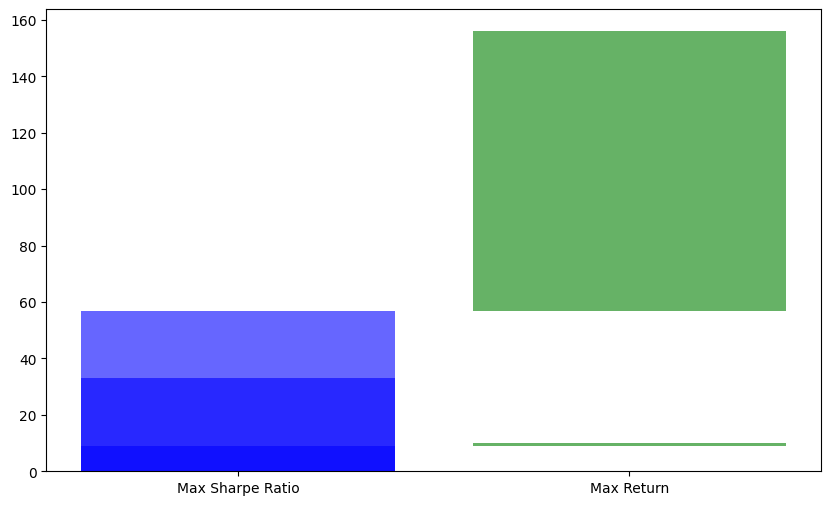

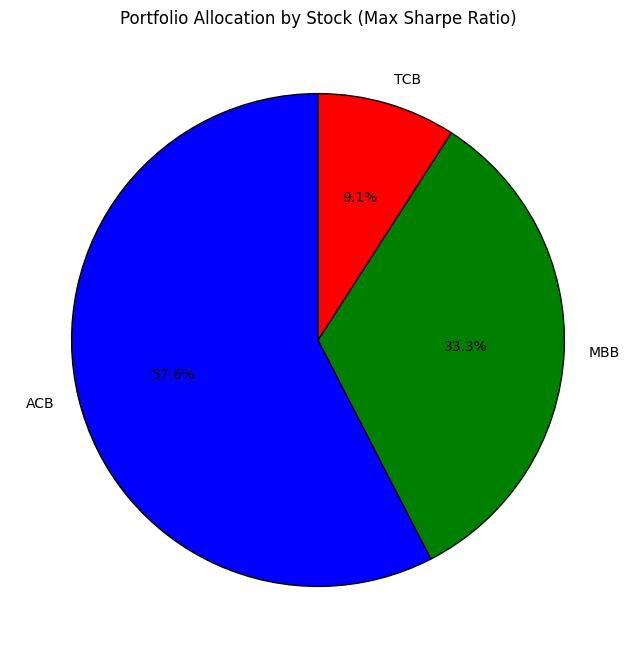

NameError: name 'bars3' is not defined

In [ ]:
def calculate_optimal_portfolio(symbols, price, port, no_of_port=10000, risk_free_rate=0.0267):
    num_stocks = len(symbols)
    weight = np.zeros((no_of_port, num_stocks))
    expected_ret = np.zeros(no_of_port)
    expected_vol = np.zeros(no_of_port)
    sharpe_ratio = np.zeros(no_of_port)

    port_ret = np.log(price / price.shift(1))

    for i in range(no_of_port):
        weight_random = np.random.random(num_stocks)
        weight_random /= np.sum(weight_random)
        weight[i, :] = weight_random
        expected_ret[i] = np.sum(port["AnnualReturn"] * weight_random)
        expected_vol[i] = np.sqrt(
            np.dot(weight_random.T, np.dot(port_ret.cov() * 252, weight_random))
        )
        sharpe_ratio[i] = (expected_ret[i] - risk_free_rate) / expected_vol[i]

    max_sharpe_index = sharpe_ratio.argmax()
    max_return_index = expected_ret.argmax()
    min_risk_index = expected_vol.argmin()

    optimal_portfolio = pd.DataFrame(
        {
            "Symbols": symbols,
            "Max Sharpe Weight": weight[max_sharpe_index, :].round(decimals=2) * 100,
            "Max Return Weight": weight[max_return_index, :].round(decimals=2) * 100,
            "Min Risk Weight": weight[min_risk_index, :].round(decimals=2) * 100,
        }
    )

    return optimal_portfolio


optimal_portfolio = calculate_optimal_portfolio(symbols, price, port)
# Plot the portfolio weights
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Max Sharpe Ratio weights
bars1 = ax.bar(
    ["Max Sharpe Ratio"] * len(optimal_portfolio["Symbols"]),
    optimal_portfolio["Max Sharpe Weight"],
    label="Max Sharpe Ratio",
    color="blue",
    alpha=0.6,
)

# Plot Max Return weights
bars2 = ax.bar(
    ["Max Return"] * len(optimal_portfolio["Symbols"]),
    optimal_portfolio["Max Return Weight"],
    label="Max Return",
    color="green",
    alpha=0.6,
    bottom=optimal_portfolio["Max Sharpe Weight"],
)

# Plot Min Risk weights
# Create a pie chart for the portfolio weights
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    optimal_portfolio["Max Sharpe Weight"],
    labels=optimal_portfolio["Symbols"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["blue", "green", "red"],
    wedgeprops={"edgecolor": "black"},
)
ax.set_title("Portfolio Allocation by Stock (Max Sharpe Ratio)")
plt.show()

# Add data labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.2f}%",
            xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

# Set labels and title
ax.set_xlabel("Loại danh mục")
ax.set_ylabel("Weight (%)")
ax.set_title("Optimal Portfolio Weights")
ax.legend(loc="upper right")

plt.show()

In [ ]:
port_ret.corr()

,ACB,HPG,FPT
ACB,1.000000,0.371696,0.426565
HPG,0.371696,1.000000,0.396959
FPT,0.426565,0.396959,1.000000


In [ ]:
port_ret.cov()

,ACB,HPG,FPT
ACB,0.000304,0.000133,0.000137
HPG,0.000133,0.000419,0.000149
FPT,0.000137,0.000149,0.000338


In [ ]:
num_stocks = len(symbols)

In [ ]:
from datetime import datetime, timedelta

headers = {
    # "X-Request-Id": id,
    "pgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36 Edg/122.0.0.0",
}


def cf_analysis(stock, period):
    try:
        today = datetime.now()
        start_date = today - timedelta(days=period)
        all_data = []

        for i in range(period + 1):
            date = start_date + timedelta(days=i)
            date = date.strftime("%Y-%m-%d")
            api_url = f"https://api-finfo.vndirect.com.vn/v4/cashflow_analysis/latest?order=time&where=code:{stock}~period:30M&filter=date:{date}"
            res = requests.get(url=api_url, headers=headers)
            res.raise_for_status()
            data = res.json()
            all_data.extend(data["data"])

        df = pd.DataFrame(all_data)
        return df
    except requests.exceptions.RequestException as e:
        print("Yêu cầu không thành công:", e)
        return None

In [ ]:
df = cf_analysis("HPG", 30)

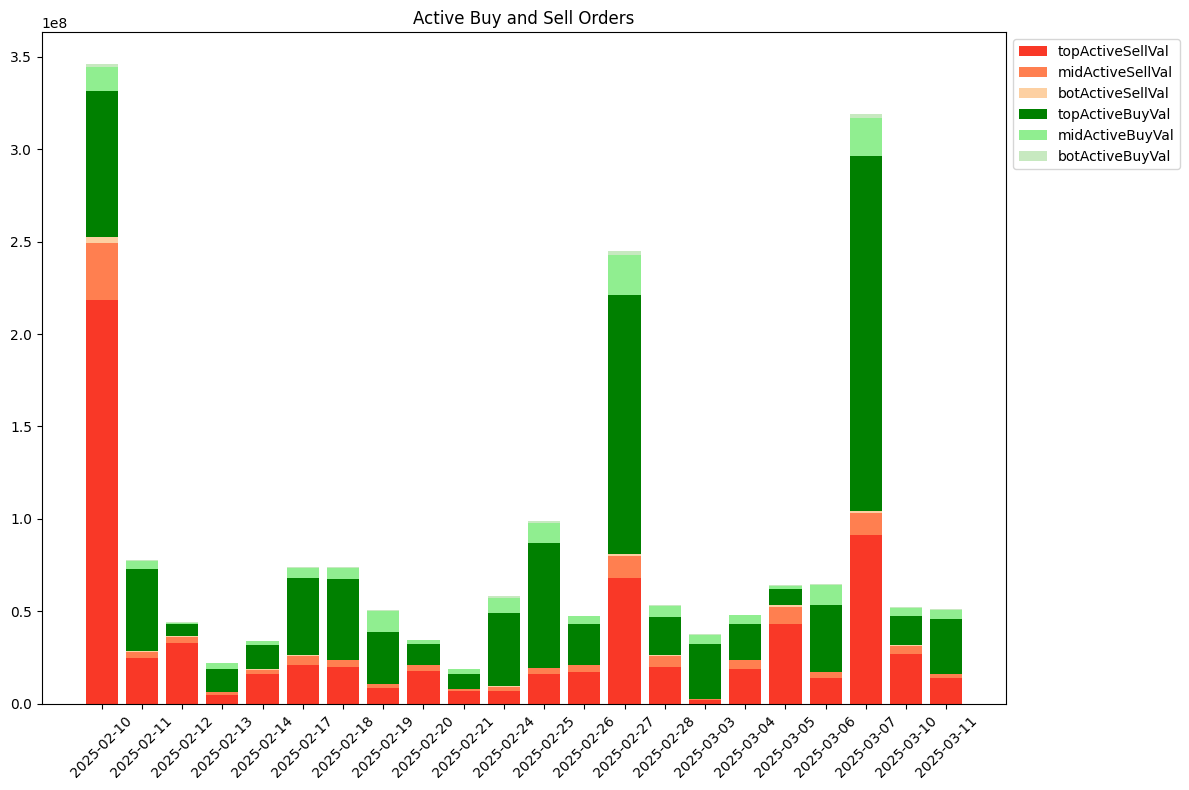

In [ ]:
# Extract the relevant columns for the bar chart
buy_columns = ["topActiveBuyVal", "midActiveBuyVal", "botActiveBuyVal"]
sell_columns = ["topActiveSellVal", "midActiveSellVal", "botActiveSellVal"]
df = cf_analysis("HPG", 30)
# Create a new DataFrame for the bar chart
df_stacked = df[["date"] + buy_columns + sell_columns]

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
buy_colors = ["green", "lightgreen", "#c7e9c0"]  # Green shades for buy orders
sell_colors = ["#F93827", "coral", "#fdd0a2"]  # Red shades for sell orders

# Plot sell orders
bottom_sell = np.zeros(len(df_stacked))
for col, color in zip(sell_columns, sell_colors):
    ax.bar(df_stacked["date"], df_stacked[col], bottom=bottom_sell, label=col, color=color)
    bottom_sell += df_stacked[col]

# Plot buy orders on top of sell orders
bottom_buy = bottom_sell.copy()
for col, color in zip(buy_columns, buy_colors):
    ax.bar(df_stacked["date"], df_stacked[col], bottom=bottom_buy, label=col, color=color)
    bottom_buy += df_stacked[col]

# Set labels and title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Active Buy and Sell Orders")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:

def filter_stocks(market_cap_min=10000000000000, net_bought_val_avg_20d_min=100000000):
    url = "https://screener-api.vndirect.com.vn/search_data"
    payload = {
        "fields": "code,companyNameVi,floor,priceCr,quarterReportDate,annualReportDate,marketCapCr,netForBoughtValAvgCr20d",
        "filters": [
            {"dbFilterCode": "marketCapCr", "condition": "GT", "value": market_cap_min},
            {"dbFilterCode": "netForBoughtValAvgCr20d", "condition": "GT", "value": net_bought_val_avg_20d_min}
        ],
        "sort": "code:asc"
    }
    
    headers = {
        "Content-Type": "application/json"
    }
    
    response = requests.post(url, json=payload, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data["data"])
        return df
    else:
        return {"error": f"Request failed with status code {response.status_code}"}

# Gọi hàm để lấy danh sách cổ phiếu lọc được
data = filter_stocks()
data

,priceCr,companyNameVi,code,netForBoughtValAvgCr20d,marketCapCr,quarterReportDate,floor,annualReportDate,id
0,96700.0,Tổng công ty cảng hàng không Việt Nam - CTCP,ACV,7.101500e+08,2.105111e+14,2024-12-31,UPCOM,2024-12-31,ACV
1,78600.0,Tổng Công ty Đầu tư và Phát triển Công nghiệp ...,BCM,4.276627e+09,8.135100e+13,2024-12-31,HOSE,2024-12-31,BCM
2,39700.0,Ngân hàng Thương mại Cổ phần Đầu tư và Phát tr...,BID,1.334021e+10,2.787481e+14,2024-12-31,HOSE,2024-12-31,BID
3,55400.0,Công ty Cổ phần Chứng khoán BIDV,BSI,3.845080e+09,1.235756e+13,2024-12-31,HOSE,2024-12-31,BSI
4,19550.0,Công ty cổ phần Lọc – Hóa dầu Bình Sơn,BSR,2.293532e+09,6.061477e+13,2024-12-31,HOSE,2024-12-31,BSR
...,...,...,...,...,...,...,...,...,...
78,61800.0,Công ty Cổ phần Sữa Việt Nam,VNM,9.219857e+10,1.291592e+14,2024-12-31,HOSE,2024-12-31,VNM
79,19500.0,Ngân hàng Thương mại Cổ phần Việt Nam Thịnh Vượng,VPB,1.863855e+10,1.547115e+14,2024-12-31,HOSE,2024-12-31,VPB
80,56400.0,Công ty Cổ phần Đầu tư Văn Phú - Invest,VPI,1.558017e+10,1.805080e+13,2024-12-31,HOSE,2024-12-31,VPI
81,18450.0,Công ty Cổ phần Vincom Retail,VRE,1.953392e+10,4.192427e+13,2024-12-31,HOSE,2024-12-31,VRE


In [ ]:
symbols = data["code"]
symbols

0     ACV
1     BCM
2     BID
3     BSI
4     BSR
     ... 
78    VNM
79    VPB
80    VPI
81    VRE
82    VTP
Name: code, Length: 83, dtype: object

In [ ]:
from src.plots import foreigner_trading_stock

# stocks.sort_index(axis=1, inplace=True)

In [ ]:
stocks.sort_index(axis=1,ascending=False, inplace=True)
stocks_sorted = stocks.loc[:, stocks.iloc[-1].sort_values(ascending=False).index].T
stocks_sorted.head(20)


NameError: name 'stocks' is not defined

In [7]:
def filter_stocks(start,end,market_cap_min=10000000000000, net_bought_val_avg_20d_min=100000000):
    url = "https://screener-api.vndirect.com.vn/search_data"
    payload = {
        "fields": "code,companyNameVi,floor,priceCr,quarterReportDate,annualReportDate,marketCapCr,netForBoughtValAvgCr20d",
        "filters": [
            {"dbFilterCode": "marketCapCr", "condition": "GT", "value": market_cap_min},
            {"dbFilterCode": "netForBoughtValAvgCr20d", "condition": "GT", "value": net_bought_val_avg_20d_min}
        ],
        "sort": "code:asc"
    }
    
    headers = {
        "Content-Type": "application/json"
    }
    
    response = requests.post(url, json=payload, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data["data"])
    else:
        return {"error": f"Request failed with status code {response.status_code}"}

    symbols = df["code"]

    stocks = pd.DataFrame()
    for symbol in symbols:
        foreign = foreigner_trading_stock(symbol, start,end)
        curr = foreign["currentRoom"]
        total = foreign["totalRoom"]
        stocks[symbol] = round((total - curr) / total, 4) * 100

    stocks.sort_index(axis=0, ascending=False, inplace=True)
    stocks_sorted = stocks.loc[:, stocks.iloc[-1].sort_values(ascending=False).index].T
    return stocks_sorted
filter_stocks("2025-03-15","2025-03-20").head(20)

NameError: name 'foreigner_trading_stock' is not defined

In [ ]:
# Sắp xếp các cột của DataFrame `stocks` theo giá trị của dòng cuối cùng
# Tạo bảng giá trị tăng trưởng mỗi cổ phiếu
growth_rate = stocks_sorted.pct_change()
# growth_rate_df = pd.DataFrame(growth_rate, columns=["Growth Rate (%)"])
growth_rate.head(30)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
MBB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VIB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OIL,-inf,0.000000,-inf,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000100,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HDB,-1.000000,-0.016700,-1.000000,-0.013800,-0.014000,-0.012600,-0.012500,-0.012800,-0.011401,-0.008300,...,-0.008700,-0.009400,-0.010300,-0.005300,-0.005700,-0.005100,-0.002600,-0.005700,-0.004100,0.000000
TPB,-0.049980,-0.045866,-0.049737,-0.047759,-0.047667,-0.049119,-0.047190,-0.036973,-0.033991,-0.025613,...,0.002219,0.009489,0.010407,0.005328,0.005733,0.005126,0.002607,0.005733,0.004117,0.000000
PNJ,0.056886,0.056811,0.061294,0.064849,0.064750,0.064544,0.062281,0.050805,0.047230,0.034565,...,0.006543,0.000000,0.000000,0.000000,0.000000,-0.002300,-0.002200,-0.002300,-0.000300,0.000000
TCB,0.011736,0.008573,0.004419,0.000000,0.000200,0.000500,0.000500,0.001001,0.000000,0.000300,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002305,0.002205,0.002305,0.000300,0.000000
MSB,-0.079800,-0.082300,-0.081700,-0.082700,-0.082800,-0.082900,-0.082400,-0.082100,-0.081400,-0.082200,...,-0.081700,-0.081900,-0.081900,-0.081900,-0.081900,-0.082000,-0.083300,-0.083800,-0.084300,-0.083800
MWG,0.022495,0.024736,0.023522,0.027036,0.023877,0.022680,0.020270,0.019610,0.015132,0.015254,...,0.008385,0.006753,0.005991,0.009040,0.013833,0.008715,0.002727,-0.004693,-0.003713,-0.000327
FPT,-0.051334,-0.045938,-0.045537,-0.044475,-0.039186,-0.035185,-0.032044,-0.030238,-0.027775,-0.026401,...,-0.019114,-0.017310,-0.016457,-0.017487,-0.019875,-0.012743,-0.006201,0.000877,-0.000877,-0.003603


In [ ]:
growth_rate.head(20)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
MBB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VIB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OIL,-inf,0.000000,-inf,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HDB,-100.000000,-1.670000,-100.000000,-1.380000,-1.400000,-1.260000,-1.250000,-1.280000,-1.140114,-0.830000,...,-0.870000,-0.940000,-1.030000,-0.530000,-0.570000,-0.510000,-0.260000,-0.570000,-0.410000,0.000000
TPB,-4.997968,-4.586596,-4.973663,-4.775908,-4.766734,-4.911890,-4.718987,-3.697326,-3.399090,-2.561258,...,0.221931,0.948920,1.040719,0.532824,0.573268,0.512614,0.260678,0.573268,0.411688,0.000000
PNJ,5.688623,5.681091,6.129411,6.484932,6.474973,6.454361,6.228079,5.080467,4.723008,3.456483,...,0.654253,0.000000,0.000000,0.000000,0.000000,-0.230000,-0.220000,-0.230000,-0.030000,0.000000
TCB,1.173614,0.857287,0.441945,0.000000,0.020004,0.050025,0.050025,0.100100,0.000000,0.030009,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.230530,0.220485,0.230530,0.030009,0.000000
MSB,-7.980000,-8.230000,-8.170000,-8.270000,-8.280000,-8.290000,-8.240000,-8.210000,-8.140000,-8.220000,...,-8.170000,-8.190000,-8.190000,-8.190000,-8.190000,-8.200000,-8.330000,-8.380000,-8.430000,-8.380000
MWG,2.249511,2.473575,2.352172,2.703587,2.387702,2.268019,2.027027,1.960998,1.513172,1.525387,...,0.838506,0.675308,0.599063,0.904041,1.383292,0.871460,0.272717,-0.469330,-0.371301,-0.032744
FPT,-5.133383,-4.593790,-4.553676,-4.447511,-3.918646,-3.518499,-3.204443,-3.023827,-2.777480,-2.640052,...,-1.911447,-1.731040,-1.645734,-1.748705,-1.987538,-1.274298,-0.620104,0.087729,-0.087690,-0.360301


12/21/2024
11/16/2024
11/14/2024
11/10/2024
11/06/2024
10/22/2024
09/30/2024
09/16/2024
05/30/2024
12/17/2023
10/16/2023
10/03/2023
08/29/2023
07/24/2023
07/13/2023
10/28/2022
10/15/2022
10/12/2022
09/24/2022
08/22/2022
08/07/2022
06/28/2022
